# PK/PD AL Model Calibration

## Checking model status/efficacy after changing how lumefantrine concentration in the blood is reported

### From ```v_concentration_in_blood.push_back( (y0[1]) / central_volume_of_distribution )```, where the central volume of distribution is in liters and the concentration is in mg/L 

### To: 
### ```patient_blood_volume_litres = patient_blood_volume/pow(10,6)```
### ```v_concentration_in_blood.push_back( (y0[1]) / patient_blood_volume_litres )```

<br>

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

In [2]:
# Define the range for weight_art
min_weight = 1
max_weight = 75

# Define weight_art values
weight_values = np.linspace(min_weight, max_weight, 75) 

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(weight_values))
failed_treatment_count_values = np.zeros(len(weight_values))

print(weight_values)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75.]


In [3]:
def run_simulation_art_weight_adj(idx, weight, n_patients):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [6]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

n_patients = 500  # Number of patients for each simulation

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i], n_patients) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'Efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_vs_efficacy_blood_volume_lum.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_weight_vs_efficacy_results_blood_volume_lum.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_vs_efficacy_results_blood_volume_lum.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 75/75 [02:01<00:00,  1.62s/it]  

DataFrame saved as pickle and CSV files successfully.


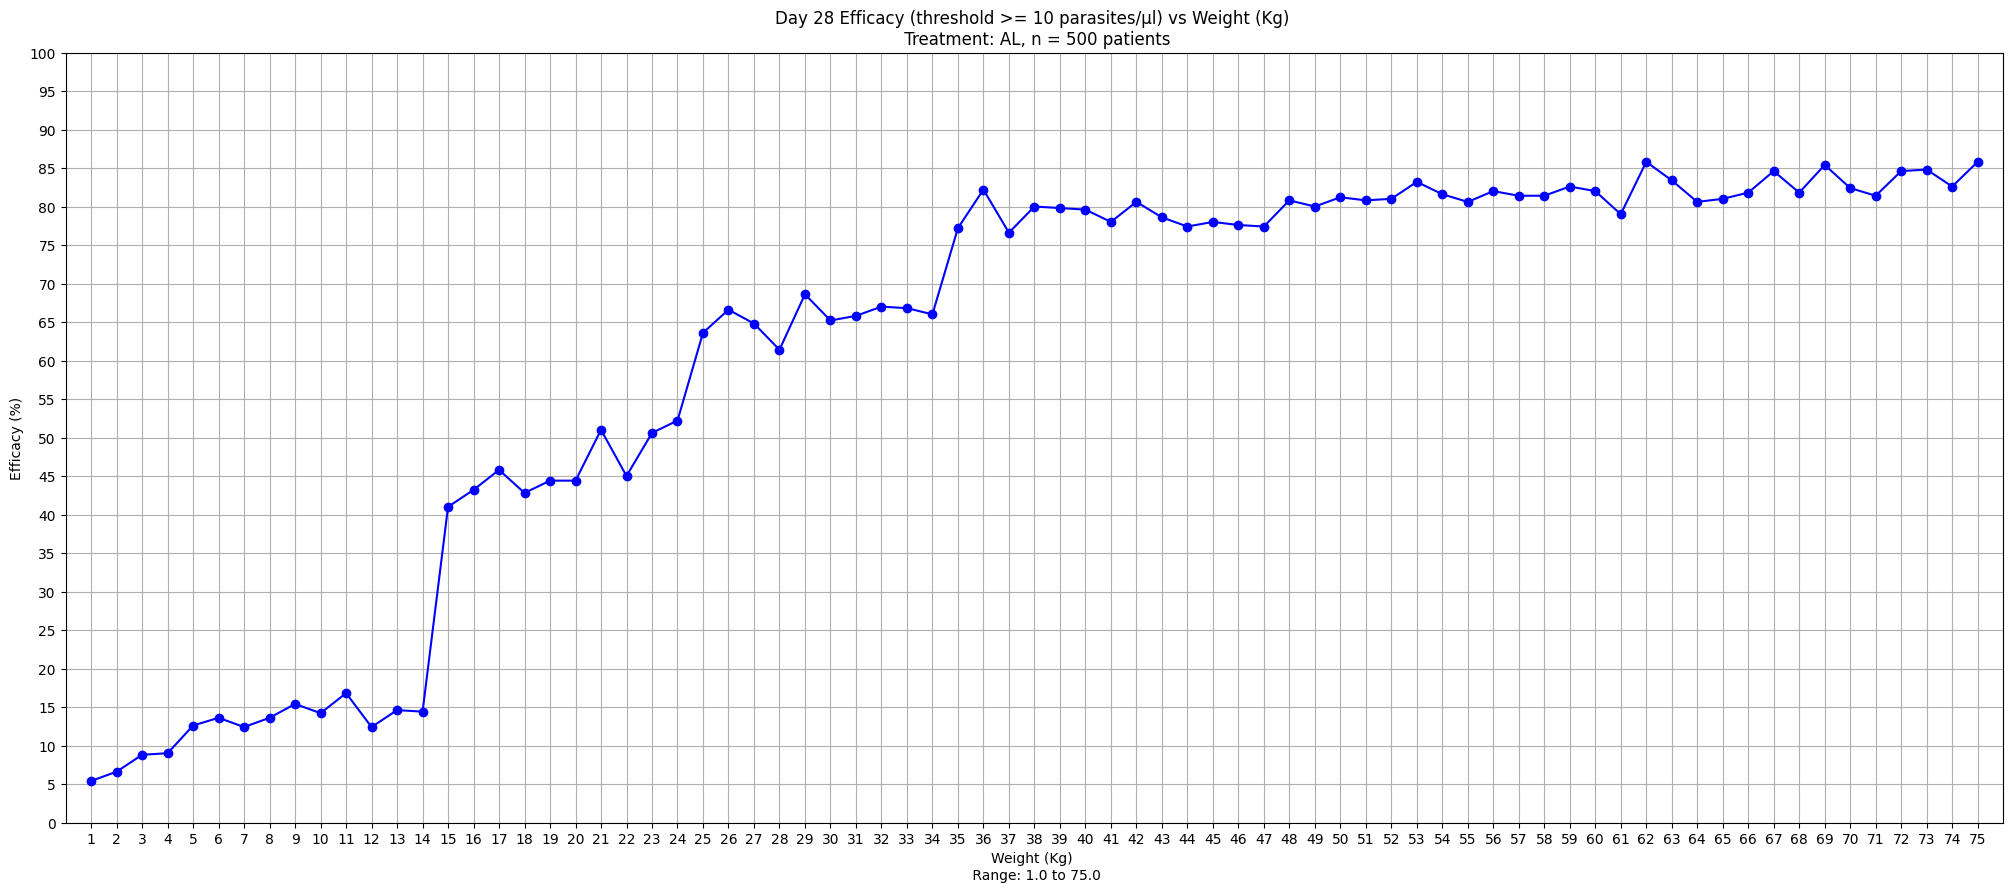

In [8]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'Weight (Kg) \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(0, max(weight_values)+1)  # Set x-axis limits
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
#plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_vs_efficacy_results_blood_volume_lum.png")  # Save the plot as a PNG file
plt.show()

### Function call to examine state values of one weight group

In [10]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [11]:
# Define the weight values to use
weight_values = [10, 15, 20, 30, 40, 50]
#weight_values = [10]

# File suffix for saving results
file_suffix = "_blood_volume_lum"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-03 

Length of simulation:  0:00:26.065700 


The failed treatment count for weight 10kg is: 846

The percentage efficacy for weight 10kg is: 15.400000000000006 


Today's date:  2025-06-03 

Length of simulation:  0:00:26.108077 


The failed treatment count for weight 15kg is: 592

The percentage efficacy for weight 15kg is: 40.800000000000004 


Today's date:  2025-06-03 

Length of simulation:  0:00:26.646313 


The failed treatment count for weight 20kg is: 533

The percentage efficacy for weight 20kg is: 46.699999999999996 


Today's date:  2025-06-03 

Length of simulation:  0:00:25.268685 


The failed treatment count for weight 30kg is: 322

The percentage efficacy for weight 30kg is: 67.8 


Today's date:  2025-06-03 

Length of simulation:  0:00:25.450037 


The failed treatment count for weight 40kg is: 207

The percentage efficacy for weight 40kg is: 79.3 


Today's date:  2025-06-03 

Length of simulation:  0:00:25.082754 


The failed treatment co

In [12]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40, 50]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40, 50],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv(f"efficacy_results_compiled_{file_suffix}.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle(f"efficacy_results_compiled_{file_suffix}.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     846      15.4
1      20                     533      46.7
2      30                     322      67.8
3      40                     207      79.3
4      50                     188      81.2


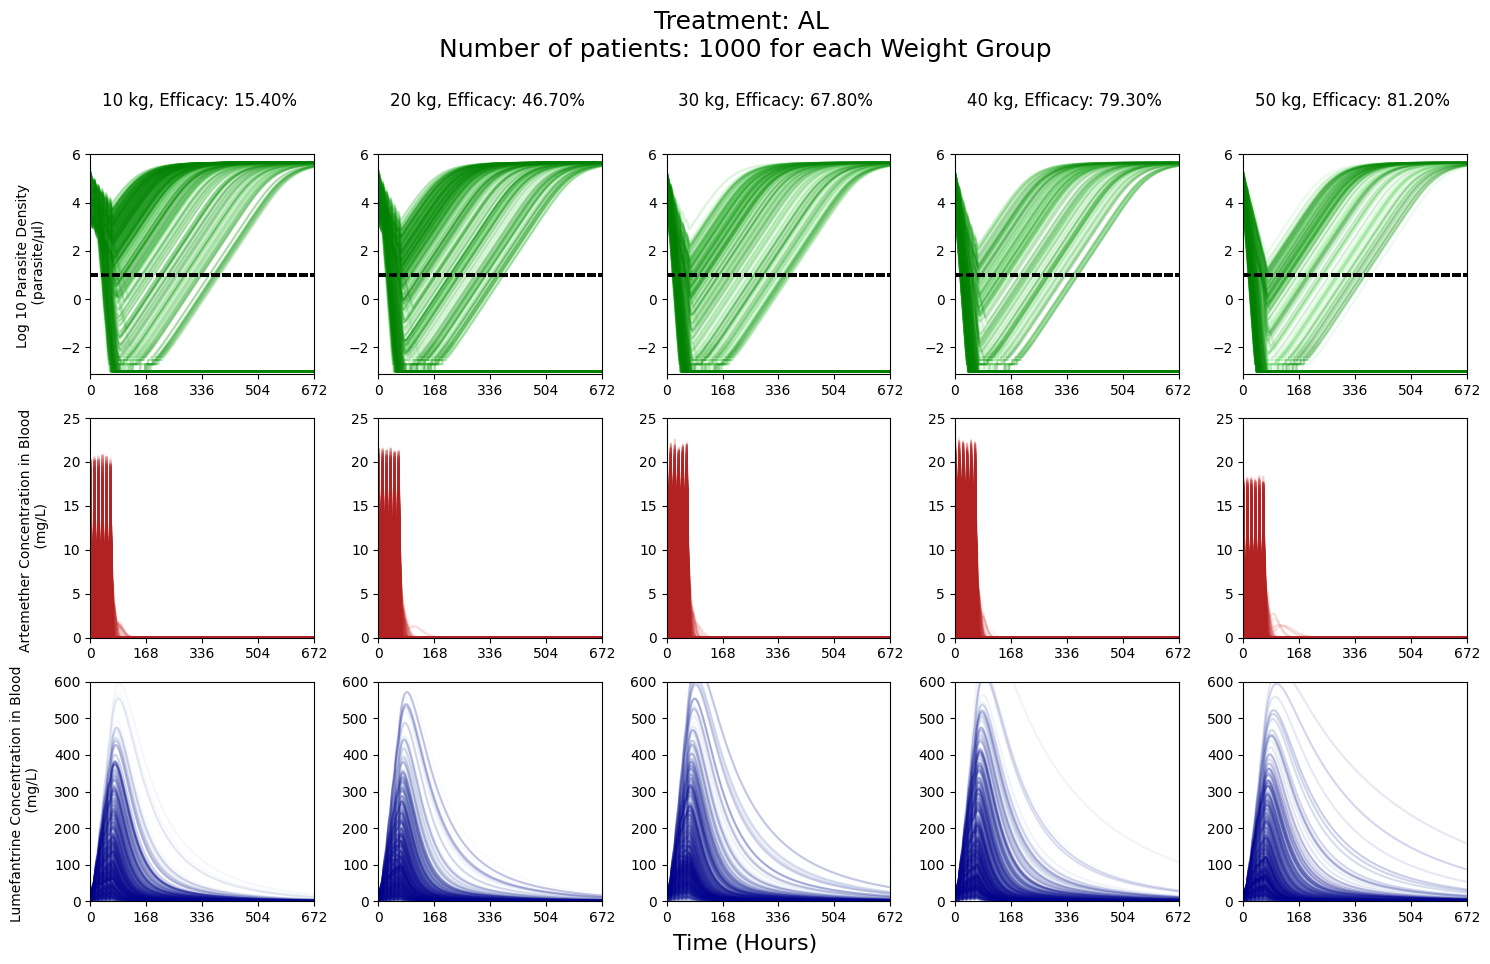

In [32]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--') 

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 600)
        ax[2, i].set_yticks(range(0, 700, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 672)
        ax[j, i].set_xticks(range(0, 673, 168))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}.png")
plt.show()


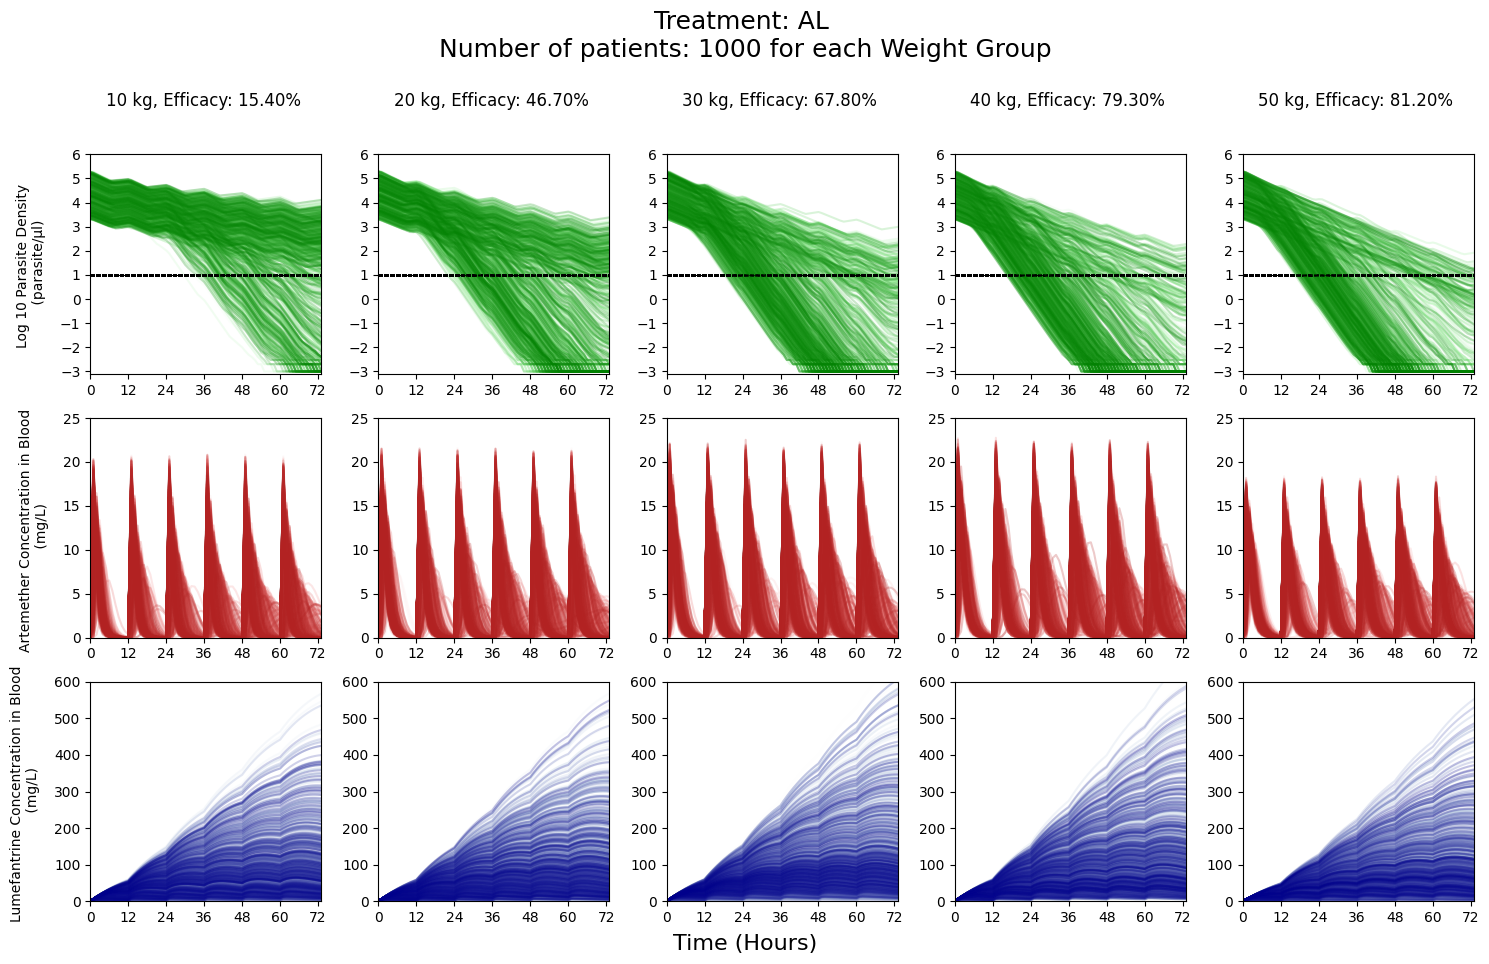

In [39]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3.1, 6)  # Set y-axis limits for Parasite Density
        ax[0, i].set_yticks(range(-3, 7, 1)) 
        ax[0, i].axhline(y=np.log10(10), color='black', linestyle='--', linewidth=0.8, alpha=0.25)
  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 600)
        ax[2, i].set_yticks(range(0, 700, 100))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, (24*3)+1)
        ax[j, i].set_xticks(range(0, 73, 12))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig(f"df_weight_efficacy_{file_suffix}_72h.png")
plt.show()
